In [98]:
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [99]:
hp, hc = get_td_waveform(
    approximant="IMRPhenomXPHM",
    mass1=30,           # Solar masses
    mass2=25,           # Solar masses  
    delta_t=1.0/4096,   # Time step
    spin1z = 0.3,
    spin2z = 0.2,
    distance = np.random.uniform(300,800),
    inclination = np.random.uniform(0,np.pi),
    f_lower=20         # Starting frequency (Hz)
)

In [100]:
print(f"Success! Generated {len(hp)} data points")
print(f"Signal duration: {len(hp) * hp.delta_t:.2f} seconds")

Success! Generated 131072 data points
Signal duration: 32.00 seconds


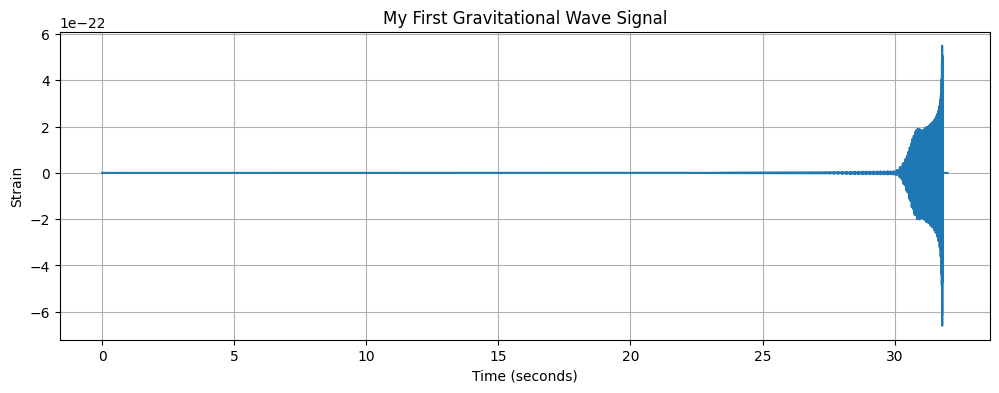

In [101]:
time = [i * hp.delta_t for i in range(0, len(hp))]

plt.figure(figsize=(12, 4))
plt.plot(time, hp)
plt.xlabel('Time (seconds)')
plt.ylabel('Strain')
plt.title('My First Gravitational Wave Signal')
plt.grid(True)
plt.show()

In [102]:
frequencies, times, Sxx = signal.spectrogram(
    hp,
    fs=4096,
    window='hann',
    nperseg=1024,
    noverlap=512    
)

print(f"Frequencies shape: {frequencies.shape}")
print(f"Times shape: {times.shape}")  
print(f"Sxx shape: {Sxx.shape}")

Frequencies shape: (513,)
Times shape: (255,)
Sxx shape: (513, 255)


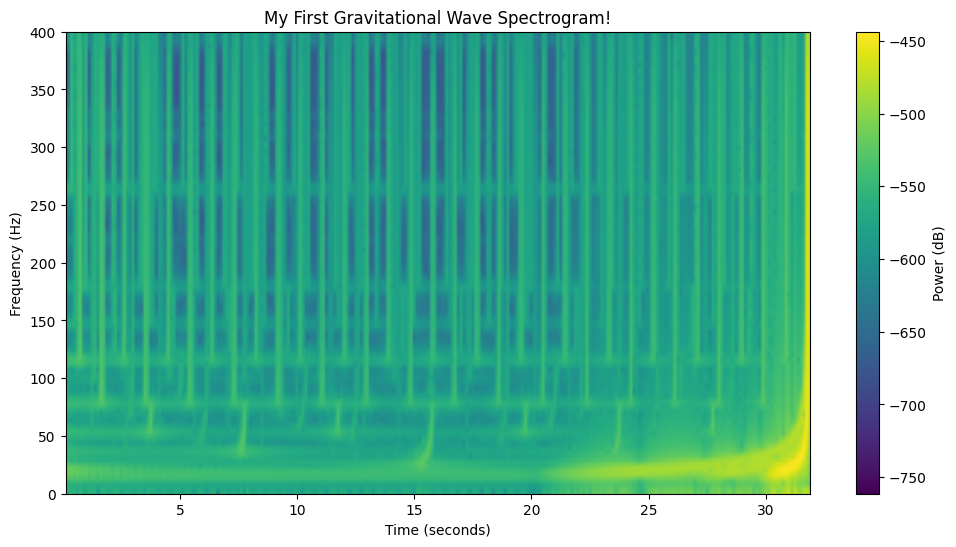

In [103]:
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, 10*np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (seconds)')
plt.title('My First Gravitational Wave Spectrogram!')
plt.colorbar(label='Power (dB)')
plt.ylim(0, 400)  # Focus on GW frequency range
plt.show()

In [104]:
#Noise
from pycbc.noise import noise_from_psd
from pycbc.psd import aLIGOZeroDetHighPower

noise = noise_from_psd(
    length = len(hp),
    delta_t = hp.delta_t,
    psd = aLIGOZeroDetHighPower(
        length = len(hp)//2+1,
        delta_f = 1.0/(len(hp)*hp.delta_t),
        low_freq_cutoff = 20
    ),
    seed =42
)

print(f"Generated noise: {len(noise)} samples")
print(f"Noise duration: {len(noise) * noise.delta_t:.2f} seconds")

Generated noise: 131072 samples
Noise duration: 32.00 seconds


In [105]:
target_snr = 5
signal = hp.numpy()
noise = noise.numpy()

signal_power = np.sqrt(np.mean(signal**2))
noise_power = np.sqrt(np.mean(noise**2))

current_snr = signal_power/noise_power
scaling_factor = target_snr/current_snr

scaled_signal = signal*scaling_factor
injected = scaled_signal + noise

In [106]:
pure_noise = noise.copy()

print(f"Pure noise max: {max(abs(pure_noise)):.2e}")

Pure noise max: 1.23e-21


In [107]:
# Calculate the actual SNR
snr = np.std(scaled_signal) / np.std(noise)
print(f"Signal-to-Noise Ratio: {snr:.1f}")

Signal-to-Noise Ratio: 5.0


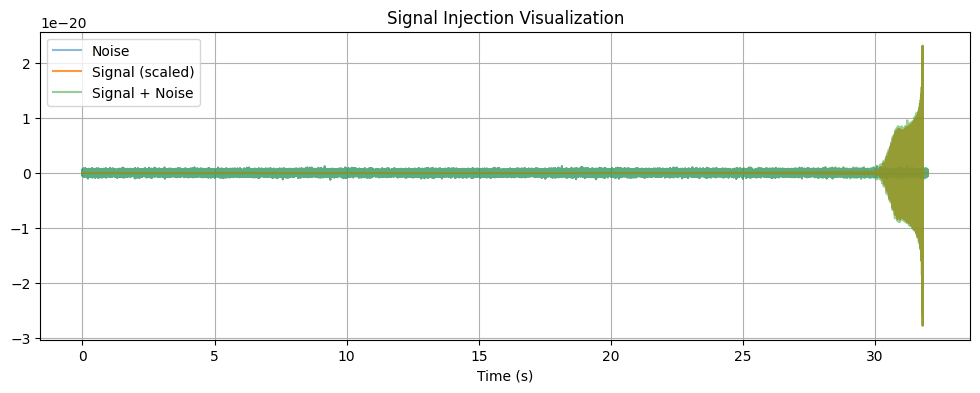

In [110]:
plt.figure(figsize=(12, 4))
plt.plot(time, noise, label='Noise', alpha=0.5)
plt.plot(time, scaled_signal, label='Signal (scaled)', alpha=0.8)
plt.plot(time, injected, label='Signal + Noise', alpha=0.5)
plt.legend()
plt.title("Signal Injection Visualization")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

In [111]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
